# extract features from scripts

In [12]:
# 'train', 'val', 'test2016', 'test2017', 'testcoco'
! python get_img_feat_vit.py \
    --dataset train \
    --path /opt/data/private/dsy/project/dataset/flickr30k \
    --model vit_base_patch16_clip_384.laion2b_ft_in12k_in1k \
    --checkpoint-path /opt/data/private/dsy/project/checkpoint/vit_base_patch16_clip_384.laion2b_ft_in12k_in1k/pytorch_model.bin \
    --save-dir /opt/data/private/dsy/project/dataset/multi30k-dataset/data/image_feat_2/vit_base_patch16_384

extracting train's image feature from vit_base_patch16_clip_384.laion2b_ft_in12k_in1k from /opt/data/private/dsy/project/checkpoint/vit_base_patch16_clip_384.laion2b_ft_in12k_in1k/pytorch_model.bin
100%|█████████████████████████████████████| 29000/29000 [17:22<00:00, 27.82it/s]
feature shape: torch.Size([29000, 577, 768]) ,save in: /opt/data/private/dsy/project/dataset/multi30k-dataset/data/image_feat_2/vit_base_patch16_384/train.pth


# timm

In [1]:
from PIL import Image
import timm

img_path = "/opt/data/private/dsy/project/dataset/flickr30k/flickr30k-images/1018148011.jpg"
checkpoint_path = "/opt/data/private/dsy/project/checkpoint/vit_base_patch16_clip_384.laion2b_ft_in12k_in1k/pytorch_model.bin"
img = Image.open(img_path)
img = img.convert("RGB")

model = timm.create_model(
    "vit_base_patch16_clip_384.laion2b_ft_in12k_in1k",
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)
timm.models.load_checkpoint(model, checkpoint_path, strict=False)
model = model.to('cuda:0')
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

# output = model(transforms(img).unsqueeze(0))  # output is (batch_size, num_features) shaped tensor

# or equivalently (without needing to set num_classes=0)
inputs = transforms(img).unsqueeze(0)
inputs = inputs.to('cuda:0')
output = model.forward_features(inputs)
# output is unpooled, a (1, 577, 768) shaped tensor

# output = model.forward_head(output, pre_logits=True)
# output is a (1, num_features) shaped tensor


/opt/data/private/dsy/project/opt/anaconda3/envs/mt/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
import torch
print(output.shape)
print(inputs.shape)
t1, t2 = inputs[0], inputs[0]
t3 = torch.stack([t1, t2], dim=0)
t3 = t3.to('cuda:0')
output = model.forward_features(inputs)
print(t3.shape)
print(data_config)
print(torch.sum(t1 == inputs[0]))
print(t1 is not None)

torch.Size([1, 577, 768])
torch.Size([1, 3, 384, 384])
torch.Size([2, 3, 384, 384])
{'input_size': (3, 384, 384), 'interpolation': 'bicubic', 'mean': (0.48145466, 0.4578275, 0.40821073), 'std': (0.26862954, 0.26130258, 0.27577711), 'crop_pct': 1.0, 'crop_mode': 'squash'}
tensor(442368, device='cuda:0')
True


In [9]:
import torch
# pth_path = "/opt/data/private/dsy/project/dataset/multi30k-dataset/data/image_feat/vit_base_patch16_384/valid.pth"
pth_path = "/opt/data/private/dsy/project/dataset/multi30k-dataset/data/image_feat_2/vit_base_patch16_384/test.pth"
pth = torch.load(pth_path)
print(pth.shape)

torch.Size([1000, 577, 768])


In [10]:
print(output[0])
print(pth[0])

tensor([[ 2.0303, -2.8959,  0.5578,  ...,  0.3642, -0.2425,  0.5970],
        [-1.1867,  0.0409,  0.8525,  ...,  0.4032, -0.9107,  0.9110],
        [-1.4743, -1.1520, -1.1235,  ...,  1.0775,  0.6073,  1.5076],
        ...,
        [-1.5671,  1.9517,  0.5999,  ..., -0.9825, -0.0976, -1.9797],
        [-1.4733,  3.1532, -0.1669,  ..., -0.2145,  0.9440, -1.5680],
        [-2.2663,  1.5522,  0.6413,  ..., -0.7852, -0.6481, -0.7480]],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor([[ 1.1316, -0.8405, -0.1223,  ...,  1.1782, -0.4806,  0.9688],
        [-1.1990,  0.4154, -1.1462,  ...,  0.2379,  0.4740,  1.7964],
        [-0.4621,  0.5443, -1.0781,  ...,  0.3802,  0.4912,  1.6906],
        ...,
        [-0.3953, -1.6833, -2.2212,  ..., -0.3885,  1.9051,  0.4934],
        [-1.2555, -1.1984, -0.5963,  ..., -0.4543,  1.0194,  0.9723],
        [ 0.4944, -2.2152, -1.0680,  ...,  0.1548, -0.2254, -0.5631]])


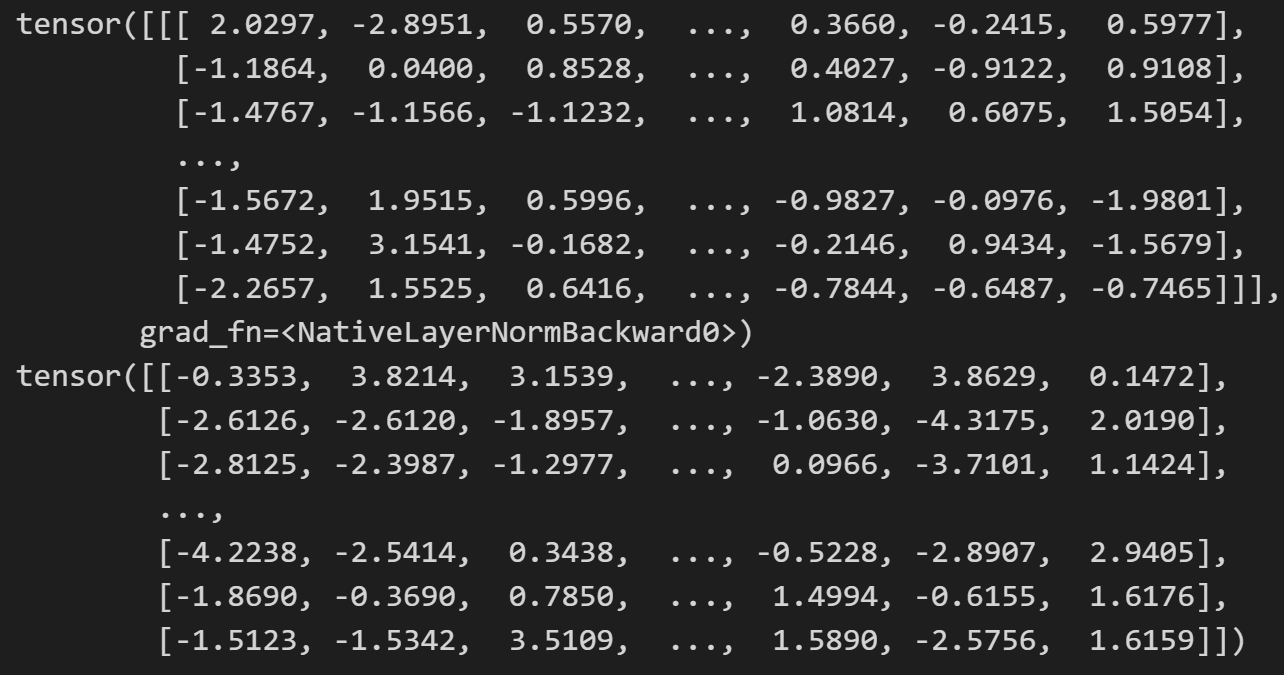